<a href="https://colab.research.google.com/github/koushikkirugulige/Football-Analytics/blob/master/xGStatsbomb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time
!git clone https://github.com/statsbomb/open-data.git

Cloning into 'open-data'...
remote: Enumerating objects: 1133, done.
remote: Counting objects: 100% (1133/1133), done.
remote: Compressing objects: 100% (632/632), done.
remote: Total 9855 (delta 925), reused 690 (delta 482), pack-reused 8722
Receiving objects: 100% (9855/9855), 996.16 MiB | 25.43 MiB/s, done.
Resolving deltas: 100% (8672/8672), done.
Checking out files: 100% (1648/1648), done.
CPU times: user 478 ms, sys: 94.4 ms, total: 572 ms
Wall time: 2min 17s


In [0]:
#import all modules
import json
import os
import codecs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from matplotlib.offsetbox import  OffsetImage
from matplotlib.patches import Ellipse
from functools import reduce
import math

In [3]:
%%time
comp = ['FIFA World Cup','La Liga']
main_df = pd.DataFrame(data=None)
path_match = "/content/open-data/data/events/" #location for play by play events
for root, dirs, files in os.walk('/content/open-data/data/matches/'):
     for file in files:
        with open(os.path.join(root, file), "r") as auto:
            with codecs.open(root + str('/') + file,encoding='utf-8') as data_file:
                data = json.load(data_file)
                df = pd.DataFrame(data=None)
                df = pd.json_normalize(data, sep = "_")
            #for x in df.competition_country_name:
            #    if x == 'Spain':
            #        print(df.match_id)
            #print(df['competition_competition_name'])
            for i in range(len(df)):
                if df.iloc[i]['competition_competition_name'] in comp  :
                    match_no = df.iloc[i]['match_id'] #gets match with Spain as country
                    match_no = str(match_no) # from int to str 
                    #print('match list \n',match_no)
                    with codecs.open(path_match + match_no + str(r'.json'),encoding="utf8") as event_file: #open the respective file
                        df_match = json.load(event_file)
                        df_match2 = pd.DataFrame(data=None)
                        df_match2 = pd.json_normalize(df_match,sep="_")    
                        df_match2 =  df_match2[(df_match2['type_name'] == "Shot")]
                    main_df = main_df.append(df_match2,ignore_index=True,sort=False)                    
#print('total matches ',len(match_no)) 
print('Done')

Done
CPU times: user 6min 28s, sys: 1.27 s, total: 6min 29s
Wall time: 6min 30s


In [0]:
main_df.head()

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,tactics_lineup,related_events,location,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,pass_end_location,pass_type_id,pass_type_name,pass_body_part_id,pass_body_part_name,carry_end_location,under_pressure,pass_outcome_id,pass_outcome_name,ball_receipt_outcome_id,...,pass_deflected,block_deflection,substitution_outcome_id,substitution_outcome_name,substitution_replacement_id,substitution_replacement_name,ball_recovery_recovery_failure,dribble_overrun,50_50_outcome_id,50_50_outcome_name,shot_aerial_won,shot_open_goal,bad_behaviour_card_id,bad_behaviour_card_name,pass_no_touch,block_offensive,foul_committed_offensive,shot_saved_off_target,goalkeeper_shot_saved_off_target,miscontrol_aerial_won,goalkeeper_punched_out,clearance_other,ball_recovery_offensive,shot_deflected,dribble_no_touch,shot_redirect,block_save_block,injury_stoppage_in_chain,half_start_late_video_start,player_off_permanent,goalkeeper_lost_out,goalkeeper_saved_to_post,shot_follows_dribble,shot_saved_to_post,goalkeeper_shot_saved_to_post,pass_backheel,goalkeeper_lost_in_play,goalkeeper_success_out,goalkeeper_success_in_play,half_end_early_video_end
0,fb785612-71d3-44df-aae4-da6e005756de,117,1,00:02:06.532,2,6,6,1.015179,16,Shot,222,Villarreal,1,Regular Play,222,Villarreal,NaN,NaN,[1febb4f7-0e2c-43f7-96fe-51fbffaaf664],"[107.5, 27.2]",11386.0,Santiago Cazorla González,16.0,Left Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2dfa84fe-3579-4705-8d27-44b8917907e1,499,1,00:09:49.110,9,49,17,1.302674,16,Shot,222,Villarreal,4,From Throw In,222,Villarreal,NaN,NaN,[1af68944-ff3d-49a1-92a0-fe6198e73e78],"[88.3, 50.2]",25921.0,Rubén Gracia Calmache,12.0,Right Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c9d92f30-2159-4a5a-a5bf-9d1163e4b33f,587,1,00:12:58.407,12,58,24,0.521000,16,Shot,222,Villarreal,5,Other,222,Villarreal,NaN,NaN,[61239f9b-052f-42ab-8a73-3c3c3841d419],"[108.0, 40.0]",20135.0,Marcos Antonio Senna da Silva,15.0,Left Center Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26b5d67b-5fce-4a5a-8b31-b879adbb61d3,1113,1,00:24:01.266,24,1,42,0.647279,16,Shot,217,Barcelona,7,From Goal Kick,217,Barcelona,NaN,NaN,"[1d8506ef-3a55-45c7-aba9-e31204db051e, 354b60e...","[107.3, 36.1]",4913.0,Bojan Krkíc Pérez,23.0,Center Forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20528610-c092-482c-8238-6b9679328680,1343,1,00:28:38.374,28,38,49,1.023005,16,Shot,217,Barcelona,1,Regular Play,217,Barcelona,NaN,NaN,[06385378-493b-4bd8-8731-f983c4ac28d8],"[105.3, 29.4]",5503.0,Lionel Andrés Messi Cuccittini,17.0,Right Wing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
"""Distance of shot location to centre of goal"""
def distFormula(coordinate):
  a =(math.sqrt(((coordinate.location[0] - 120)**2) + ((coordinate.location[1] - 36)**2))) 
  b =(math.sqrt(((coordinate.location[0] - 120)**2) + ((coordinate.location[1] - 44)**2))) 
  return ((a+b)/2)

In [0]:
""" near x y (nx,ny) (120,44)and far x y (fx,fy) (120,36)""" 
nx = 120
ny = 44
fx = 120
fy = 36

goalpostLength = 8
def shot_angle(points):
  len1 = (math.sqrt(((points.location[0] - nx)**2) + ((points.location[1] - ny)**2))) 
  len2 = (math.sqrt(((points.location[0] - fx)**2) + ((points.location[1] - fy)**2)))
  ang = (len1**2 + len2**2 - goalpostLength**2)/(2 * len1 * len2)
  if ang > 1:
    ang = 1
  elif ang < -1:
    ang = -1   
  angRad = math.acos(ang)
  return( (angRad * 180)/math.pi) 

In [0]:
"""If shot was taken under Pressure?"""
def under_pressure(coordinate):
  if coordinate['under_pressure'] == True:
    return 1
  return 0

In [0]:
"""The Shot type Id"""
def shot_type(coordinate):
  if coordinate['shot_type_id'] == 61:
    return 1
  if coordinate['shot_type_id'] == 62:
    return 2
  if coordinate['shot_type_id'] == 87:
    return 3
  if coordinate['shot_type_id'] == 88:
    return 4
  return 5

In [0]:
"""The Shot Body part"""
def shot_body_part(coordinate):
  if coordinate['shot_body_part_id'] == 37:
    return 1
  if coordinate['shot_body_part_id'] == 38:
    return 2
  if coordinate['shot_body_part_id'] == 70:
    return 3
  return 4

In [0]:
"""The Shot Technique Id"""
def shot_technique(coordinate):
  if coordinate['shot_technique_id'] == 89:
    return 1
  if coordinate['shot_technique_id'] == 90:
    return 2
  if coordinate['shot_technique_id'] == 91:
    return 3
  if coordinate['shot_technique_id'] == 92:
    return 4
  if coordinate['shot_technique_id'] == 93:
    return 5
  if coordinate['shot_technique_id'] == 94:
    return 6
  return 7

In [0]:
"""If shot was taken first time?"""
def shot_first_time(coordinate):
  if coordinate['shot_first_time'] == True:
    return 1
  return 0

In [0]:
""" To Find if a point is inside the triangle
https://www.geeksforgeeks.org/check-whether-a-given-point-lies-inside-a-triangle-or-not/"""
def Triarea(a,b,c):
#return abs((x1*(y2-y3) + x2*(y3-y1)+ x3*(y1-y2))/2.0);   
  return abs((a[0] * (b[1] - c[1]) + b[0] * (c[1] - a[1]) + c[0] * (a[1] - b[1]))/2.0)

def isInside(a,b,c,p):
 A = Triarea(a,b,c)

 A1 = Triarea(a,b,p)

 A2 = Triarea(p,b,c)

 A3 = Triarea(a,p,c)  
 
 if (round(A,2) == round((A1 + A2 + A3),2)):
   return 1
 return 0 

In [0]:
"""If shot was taken first time?"""
def shot_one_on_one(coordinate):
  if coordinate['shot_one_on_one'] == True:
    return 1
  return 0

In [0]:
def infronofShot(frame):
  if str(type(frame['shot_freeze_frame'])) == '<class \'float\'>':
    return 0
  if not len(frame['shot_freeze_frame']):
    return 0
  #print(type(frame['shot_freeze_frame']),'\n')
  loc = pd.DataFrame(frame['shot_freeze_frame'])
  
  #loc = loc[['location']]
  X = frame['location'][0]
  Y = frame['location'][1]
  countgoal = 0
  
  for i in range(len(loc)):
    
    if isInside((X,Y),(120,36),(120,44),(loc['location'].iloc[i][0],loc['location'].iloc[i][1])) == 1:
      countgoal +=1
  return countgoal      

In [0]:
main_df['Distance'] = main_df.apply(distFormula,axis = 1)
main_df['Angle'] = main_df.apply(shot_angle,axis = 1)
main_df['UnderPressure'] = main_df.apply(under_pressure,axis = 1)
main_df['ShotType'] = main_df.apply(shot_type,axis = 1)
main_df['ShotBodyPart'] = main_df.apply(shot_body_part,axis = 1)
main_df['ShotTechnique'] = main_df.apply(shot_technique,axis = 1)
main_df['ShotFirstTime'] = main_df.apply(shot_first_time,axis = 1)
main_df['ShotOneonOne']= main_df.apply(shot_one_on_one,axis = 1)
main_df['InFrontofGoal'] = main_df.apply(infronofShot,axis = 1)

In [0]:
goals_lst = main_df[main_df['shot_outcome_id'] == 97].index.tolist()

In [0]:
#if shot is a goal 
main_df['isGoal'] = False
goals_lst
main_df.loc[main_df.index.isin(goals_lst),'isGoal'] = True

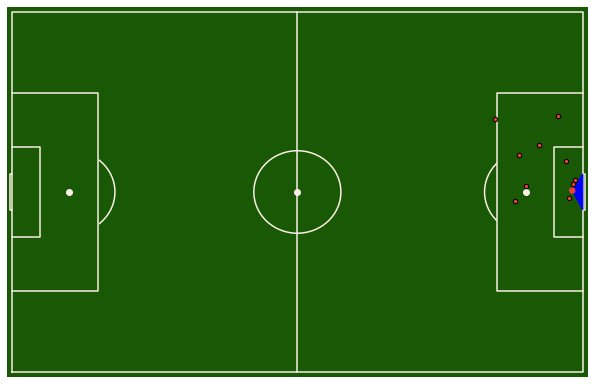

In [233]:
import statsbombpitch as sb
sb.sb_pitch("#195905","#faf0e6","horizontal","full")
ilocv = 3477
plt.scatter(main_df.iloc[ilocv]['location'][0],main_df.iloc[ilocv]['location'][1],color="#ee3e32",edgecolors="none",zorder=10,alpha=1,s = 40 )
#plt.plt.plot((main_df.iloc[0]['location'][0],120),(main_df.iloc[0]['location'][1],44),color = 'black',zorder = 10)
#(main_df.iloc[1]['location'][1],main_df.iloc[1]['location'][0],120,zorder = 10)
#plt.plot((main_df.iloc[0]['location'][0],120),(main_df.iloc[0]['location'][1],44),color = 'black',zorder = 10)
tri = np.array([[main_df.iloc[ilocv]['location'][0],main_df.iloc[ilocv]['location'][1]],[120,36],[120,44]])
t1 = plt.Polygon(tri, color = 'blue',zorder = 8)
plt.gca().add_patch(t1)
loc = pd.DataFrame(main_df.iloc[ilocv]['shot_freeze_frame'])
for i in range(len(loc)):
  plt.scatter(loc['location'].iloc[i][0],loc['location'].iloc[i][1],color="#ee3e32",edgecolors="black",zorder=10,alpha=1,s = 20 )  
plt.show()

In [237]:
sortxg[50:100]

,location,Distance,Angle,UnderPressure,ShotType,ShotBodyPart,ShotTechnique,ShotFirstTime,InFrontofGoal,ShotOneonOne,xG
10082,"[115.2, 43.6]",6.902760,62.487997,0,3,4,3,1,1,0,0.593055
11940,"[118.0, 45.0]",5.727806,50.906141,0,3,4,7,1,0,0,0.588634
5946,"[115.1, 37.6]",6.607503,70.644874,0,3,4,7,1,2,0,0.588151
4032,"[114.3, 42.8]",7.348970,61.917732,0,3,4,3,1,1,0,0.582283
10411,"[116.3, 40.1]",5.449276,94.443109,0,3,1,5,0,2,0,0.578671
10059,"[117.9, 44.7]",5.581727,57.994617,0,3,4,3,1,1,0,0.577080
5721,"[115.0, 40.0]",6.403124,77.319617,0,3,1,5,0,0,0,0.573219
10216,"[114.8, 38.0]",6.755564,70.123128,0,3,1,5,0,1,1,0.563681
4014,"[112.3, 38.2]",8.824071,52.934164,0,3,4,3,1,0,0,0.561885
8422,"[113.1, 43.4]",8.521922,51.972274,0,3,4,5,1,0,0,0.557730


In [205]:
countgoal = 0
#isInside((X,Y),(120,36),(120,44),(loc['location'].iloc[i][0],loc['location'].iloc[i][1])) == 1:
for i in range(len(loc)):
  if isInside((100.7,25.6),(120,36),(120,44),(loc['location'].iloc[i][0],loc['location'].iloc[i][1])) == 1:
    countgoal +=1
countgoal   

9

In [182]:
%%time
main_df['InFrontofGoal'] = main_df.apply(infronofShot,axis = 1)

CPU times: user 16.9 s, sys: 39.6 ms, total: 17 s
Wall time: 16.9 s


In [207]:
main_df[['location','Distance','Angle','UnderPressure','ShotType','ShotBodyPart','ShotTechnique','ShotFirstTime','ShotOneonOne','InFrontofGoal','isGoal']]

,location,Distance,Angle,UnderPressure,ShotType,ShotBodyPart,ShotTechnique,ShotFirstTime,ShotOneonOne,InFrontofGoal,isGoal
0,"[110.5, 36.2]",10.896986,40.593846,1,3,4,5,1,0,1,False
1,"[114.2, 48.0]",10.186866,29.611685,0,3,4,7,1,0,2,False
2,"[95.3, 48.3]",26.332306,16.596593,0,2,2,5,0,0,4,False
3,"[103.3, 61.6]",27.413807,10.378789,0,3,2,5,0,0,1,False
4,"[94.9, 55.2]",29.543437,13.366677,0,2,2,5,0,0,4,False
...,...,...,...,...,...,...,...,...,...,...,...
12952,"[111.0, 27.0]",15.981653,17.102729,0,3,2,5,0,0,3,False
12953,"[114.0, 33.0]",9.619084,34.824489,0,3,2,5,0,0,1,True
12954,"[107.0, 32.0]",15.646638,25.606661,0,3,2,5,0,0,1,False
12955,"[97.0, 22.0]",29.376742,12.398277,0,3,4,5,0,0,1,False


#xG Model

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn import svm
from sklearn import linear_model

In [0]:
xgModel = main_df[['location','Distance','Angle','UnderPressure','ShotType','ShotBodyPart','ShotTechnique','ShotFirstTime','ShotOneonOne','InFrontofGoal','isGoal']]

In [0]:
X_train,X_test,y_train,y_test = train_test_split(xgModel[['location','Distance','Angle','UnderPressure','ShotType','ShotBodyPart','ShotTechnique','ShotFirstTime','InFrontofGoal','ShotOneonOne']],xgModel[['isGoal']],test_size = 0.2,shuffle = True)

**Logistic Regression** Model

In [214]:
clf = LogisticRegression(random_state=0,max_iter = 5000).fit(X_train[['Distance','Angle','UnderPressure','ShotType','ShotBodyPart','ShotTechnique','ShotFirstTime','ShotOneonOne','InFrontofGoal']], y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [215]:
#model weights
clf.coef_[0]

array([-0.05881247,  0.03193658, -0.45802499,  0.59881635,  0.21925344,
       -0.00195693,  0.21331492,  0.50199851, -0.29032136])

**SGD** Model

In [0]:
xG = clf.predict_proba(X_test[['Distance','Angle','UnderPressure','ShotType','ShotBodyPart','ShotTechnique','ShotFirstTime','ShotOneonOne']])[:,1]

In [239]:
#SGD
sgdclf = linear_model.SGDClassifier(loss='log', alpha = 0.17)
sgdclf.fit(X_train[['Distance','Angle','UnderPressure','ShotType','ShotBodyPart','ShotTechnique','ShotFirstTime','ShotOneonOne','InFrontofGoal']], y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.17, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Xg Boost Model

In [245]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', max_depth=4, n_estimators=100)
xgb_model.fit(X_train[['Distance','Angle','UnderPressure','ShotType','ShotBodyPart','ShotTechnique','ShotFirstTime','ShotOneonOne','InFrontofGoal']], y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

**Predict** Shot Probability

In [0]:
# change model here sgcclf(SGD) or clf(LR)
xG = xgb_model.predict_proba(X_test[['Distance','Angle','UnderPressure','ShotType','ShotBodyPart','ShotTechnique','ShotFirstTime','ShotOneonOne','InFrontofGoal']])[:,1]

In [0]:
X_test['xG'] = xG
#X_test.head()

In [248]:
sortxg = X_test.sort_values(by = ['xG'],ascending=False)
sortxg

,location,Distance,Angle,UnderPressure,ShotType,ShotBodyPart,ShotTechnique,ShotFirstTime,InFrontofGoal,ShotOneonOne,xG
646,"[118.8, 37.0]",4.332081,120.077993,0,3,4,5,1,0,0,0.979459
10495,"[119.3, 41.4]",4.068882,157.545469,0,3,4,5,1,0,0,0.979459
2681,"[119.1, 39.6]",4.100949,154.403626,0,3,4,5,1,0,0,0.979459
5237,"[118.7, 39.4]",4.210111,143.294745,0,3,4,3,1,0,0,0.969388
7452,"[117.7, 37.8]",4.766741,107.693813,0,3,2,5,1,0,0,0.967390
...,...,...,...,...,...,...,...,...,...,...,...
505,"[58.1, 28.1]",63.155775,7.132821,0,3,4,5,0,1,0,0.004881
11160,"[61.8, 39.8]",58.337636,7.863251,0,3,4,5,0,1,0,0.004881
3568,"[63.0, 30.5]",57.920804,7.813054,0,3,4,5,0,1,0,0.004881
5084,"[87.5, 67.5]",42.683234,8.235003,0,3,4,3,0,1,0,0.004615


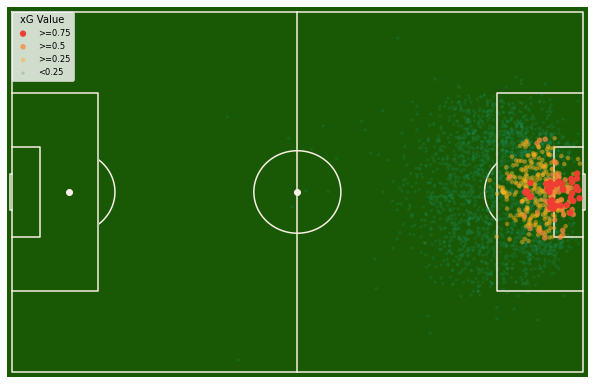

In [249]:
import statsbombpitch as sb
sb.sb_pitch("#195905","#faf0e6","horizontal","full")
plt.gca().invert_yaxis()
for i in range(len(sortxg)):
    xe = sortxg.iloc[i]['location'][0]
    ye = sortxg.iloc[i]['location'][1]
    
    if sortxg.iloc[i]['xG'] >= 0.75:
      g = plt.scatter(xe,ye,color="#ee3e32",edgecolors="none",zorder=10,alpha=1,s = 40 )
    elif sortxg.iloc[i]['xG'] < 0.75 and sortxg.iloc[i]['xG'] >=0.5:
      o = plt.scatter(xe,ye,color="#f68838",edgecolors="none",zorder=8,alpha=0.75,s = 30 )
    elif sortxg.iloc[i]['xG'] < 0.5 and sortxg.iloc[i]['xG'] >=0.25:
      a = plt.scatter(xe,ye,color="#fbb021",edgecolors="none",zorder=6,alpha=0.5,s = 20 )  
    else:
      b = plt.scatter(xe,ye,color="#1b8a5a",edgecolors="none",zorder=4,alpha=0.25,s = 10 )    
plt.axis('off')
plt.legend((g,o,a,b),('>=0.75','>=0.5','>=0.25','<0.25'),scatterpoints=1,loc=2,title = 'xG Value',fontsize='small', fancybox=True)
#plt.title('xG SGD model')
plt.savefig('xgXGBmodelFreezeFrame.png')
plt.show()

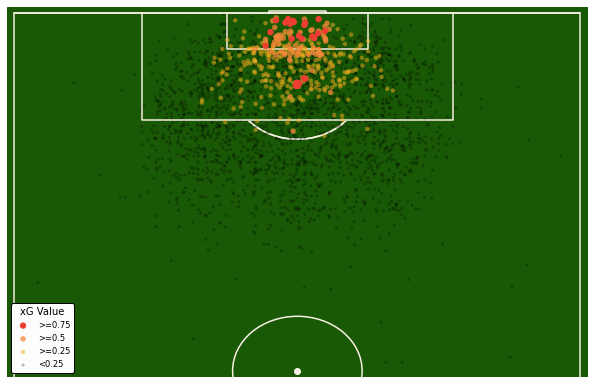

In [0]:
import StatsbombPitch as sb
sb.sb_pitch("#195905","#faf0e6","vertical","half")
#plt.gca().invert_xaxis()
for i in range(len(sortxg)):
    xe = sortxg.iloc[i]['location'][0]
    ye = sortxg.iloc[i]['location'][1]
    
    if sortxg.iloc[i]['xG'] >= 0.75:
      g = plt.scatter(ye,xe,color="#ee3e32",edgecolors="none",zorder=10,alpha=1,s = 40 )
    elif sortxg.iloc[i]['xG'] < 0.75 and sortxg.iloc[i]['xG'] >=0.5:
      o = plt.scatter(ye,xe,color="#f68838",edgecolors="none",zorder=8,alpha=0.75,s = 30 )
    elif sortxg.iloc[i]['xG'] < 0.5 and sortxg.iloc[i]['xG'] >=0.25:
      a = plt.scatter(ye,xe,color="#fbb021",edgecolors="none",zorder=6,alpha=0.5,s = 20 )  
    else:
      b = plt.scatter(ye,xe,color="#1b8a5a",edgecolors="none",zorder=4,alpha=0.25,s = 10 )    
plt.axis('off')
plt.legend((g,o,a,b),('>=0.75','>=0.5','>=0.25','<0.25'),scatterpoints=1,loc=3,title = 'xG Value',fontsize='small', fancybox=True,edgecolor = 'black',framealpha = 2
           )


#ax = plt.subplot()

#plt.savefig('MessiValverdeEraScatter.png')
plt.show()

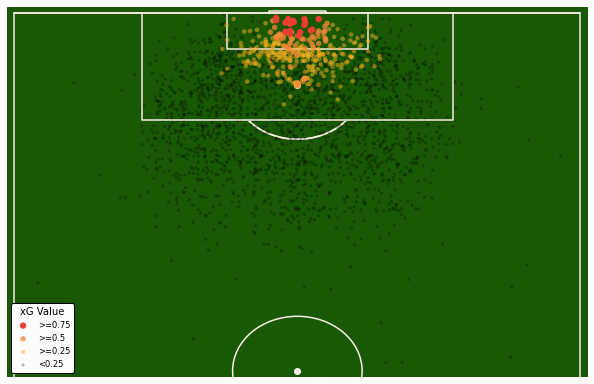

In [0]:
import StatsbombPitch as sb
sb.sb_pitch("#195905","#faf0e6","vertical","half")
#plt.gca().invert_xaxis()
for i in range(len(sortxg)):
    xe = sortxg.iloc[i]['location'][0]
    ye = sortxg.iloc[i]['location'][1]
    
    if sortxg.iloc[i]['xG'] >= 0.75:
      g = plt.scatter(ye,xe,color="#ee3e32",edgecolors="none",zorder=10,alpha=1,s = 40 )
    elif sortxg.iloc[i]['xG'] < 0.75 and sortxg.iloc[i]['xG'] >=0.5:
      o = plt.scatter(ye,xe,color="#f68838",edgecolors="none",zorder=8,alpha=0.75,s = 30 )
    elif sortxg.iloc[i]['xG'] < 0.5 and sortxg.iloc[i]['xG'] >=0.25:
      a = plt.scatter(ye,xe,color="#fbb021",edgecolors="none",zorder=6,alpha=0.5,s = 20 )  
    else:
      b = plt.scatter(ye,xe,color="black",edgecolors="none",zorder=4,alpha=0.25,s = 10 )    
plt.axis('off')
plt.legend((g,o,a,b),('>=0.75','>=0.5','>=0.25','<0.25'),scatterpoints=1,loc=3,title = 'xG Value',fontsize='small', fancybox=True,edgecolor = 'black',framealpha = 2
           )


#ax = plt.subplot()

#plt.savefig('MessiValverdeEraScatter.png')
plt.show()

In [0]:
#[['Distance','Angle','UnderPressure','ShotType','ShotBodyPart','ShotTechnique','ShotFirstTime','ShotOneonOne']]
xgb_model.predict_proba(pd.DataFrame([12.55,37.156,0,4,2,2,0,0]))[:,1]

ValueError: ignored